# Subject Models

In [33]:
import pandas as pd
import json 

with open('index.txt', 'r') as index_file:
    rows = []
    for line in index_file:
        line = line.strip()
        model_name, metadata_string = line.split(' ', maxsplit=1)
        metadata = json.loads(metadata_string)
        metadata['name'] = model_name
        rows.append(metadata)

weight_decay = pd.DataFrame(rows)

## Sparsity

In [34]:
import pandas as pd

with open("sparsity.txt", 'r') as sparsity_file:
    rows = []
    for line in sparsity_file:
        line = line.strip()
        name, sparsity = line.split(', ')
        rows.append((name, float(sparsity)))

sparsity = pd.DataFrame(rows, columns=['name', 'sparsity'])
weight_decay_sparsity = pd.merge(weight_decay[['name', 'weight_decay']], sparsity, on='name', how='inner')
weight_decay_sparsity.head()

,name,weight_decay,sparsity
0,e7134f98-b20c-4a77-ad61-6bd23f8fa203,0.0001,79.111111
1,36415ee2-5e68-44e1-8f52-2582810a58eb,0.0010,61.037037
2,f356169d-3ebc-4318-8b55-7db6b548cad2,0.0001,65.925926
3,24e48b1e-4d61-42cd-a942-81a8dedf1515,0.0001,71.407407
4,45767dac-1d1c-455b-ac3f-6e0b2027001b,1.0000,29.333333


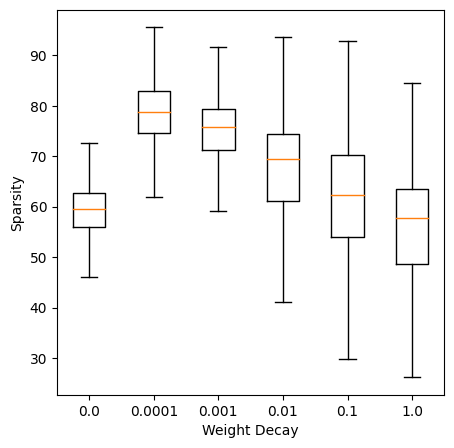

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

grouped = weight_decay_sparsity.groupby('weight_decay')
data = [group['sparsity'].tolist() for _, group in grouped]
labels = grouped.groups.keys()
ax.boxplot(data, labels=labels, showfliers=False)
ax.set_xlabel('Weight Decay')
ax.set_ylabel('Sparsity')

plt.show()

## Performance

In [36]:
# TODO: Get the losses for the other pruning amounts
with open('pruned_losses.txt', 'r') as pruned_losses:
    rows = []
    for line in pruned_losses:
        name, prune_amount, loss = line.strip().split(' ')
        rows.append((name, float(prune_amount), float(loss)))
pruned_losses = pd.DataFrame(rows, columns=['name', 'prune_amount', 'loss'])
pruned_losses['prune_amount'] = 0.2

zero_decay_rows = weight_decay[weight_decay['weight_decay'] == 0]
zero_decay_rows = zero_decay_rows.drop('loss', axis=1)
pruned_models = pd.merge(zero_decay_rows, pruned_losses, on='name', how='inner')

weight_decay['prune_amount'] = 0.
subject_models = pd.concat([weight_decay, pruned_models])

subject_models.head()

ValueError: too many values to unpack (expected 2)

In [ ]:
subject_models['fn_name'].value_counts()

fn_name
exponent          73121
sigmoid           70035
addition          70033
multiplication    70001
min               69330
Name: count, dtype: int64

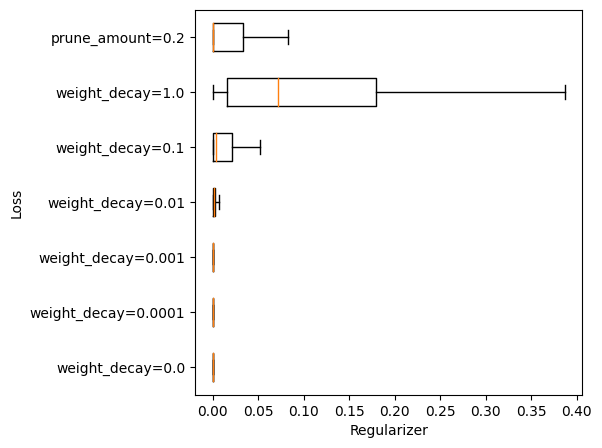

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

weight_decay_groups = subject_models[subject_models['prune_amount'] == 0.].groupby('weight_decay')
weight_decay_data = [group['loss'].tolist() for _, group in weight_decay_groups]
weight_decay_labels = [f'weight_decay={wd}' for wd in weight_decay_groups.groups.keys()]

prune_amount_groups = subject_models[(subject_models['weight_decay'] == 0.) & (subject_models['prune_amount'] > 0.)].groupby('prune_amount')
prune_amount_data = [group['loss'].tolist() for _, group in prune_amount_groups]
prune_amount_labels = [f'prune_amount={pa}' for pa in prune_amount_groups.groups.keys()]

data = weight_decay_data + prune_amount_data
labels = weight_decay_labels + prune_amount_labels


ax.boxplot(data, labels=labels, showfliers=False, vert=False)
ax.set_xlabel('Regularizer')
ax.set_ylabel('Loss')

plt.show()

# Interpretability models

In [ ]:
import wandb
from train_subject_models import FUNCTION_NAMES
from datetime import datetime

api = wandb.Api()
runs = api.runs(
    path='patrickaaleask/bounding-mi',
    filters= {
        'config.functions': FUNCTION_NAMES,
        'State': 'finished',
        'created_at': {
            '$gt': "2023-06-26T00:00:00",
        },
    },
)
print(f'Found {len(list(runs))} runs')

Found 121 runs


In [ ]:
import pandas as pd
from scipy import stats

run_data = []
for run in runs:
    if run.summary['_wandb']['runtime'] < 10:
        continue
    try:
        prune_amount = run.config['prune_amount']
    except KeyError:
        prune_amount = 0.
    run_data.append((run.config['weight_decay'], prune_amount, run.summary['validation_loss']))

interp_models = pd.DataFrame(run_data, columns=['weight_decay', 'prune_amount', 'loss'])
interp_models.head()


,weight_decay,prune_amount,loss
0,0.0,0.6,0.026971
1,0.0,0.5,0.023625
2,0.0,0.5,0.024341
3,0.0,0.5,0.023840
4,0.0,0.6,0.026517


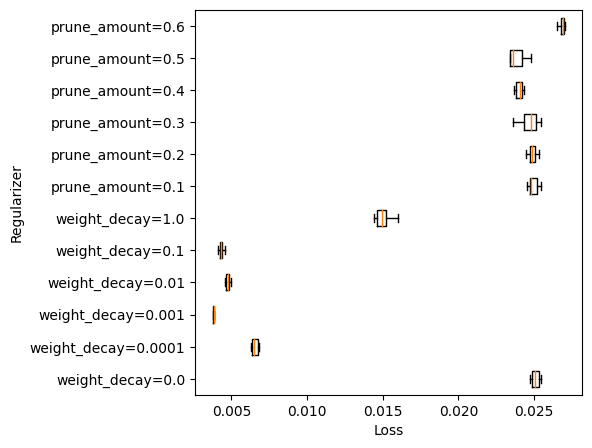

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

weight_decay_groups = interp_models[interp_models['prune_amount'] == 0.].groupby('weight_decay')
weight_decay_data = [group['loss'].tolist() for _, group in weight_decay_groups]
weight_decay_labels = [f'weight_decay={wd}' for wd in weight_decay_groups.groups.keys()]

prune_amount_groups = interp_models[(interp_models['weight_decay'] == 0.) & (interp_models['prune_amount'] > 0.)].groupby('prune_amount')
prune_amount_data = [group['loss'].tolist() for _, group in prune_amount_groups]
prune_amount_labels = [f'prune_amount={pa}' for pa in prune_amount_groups.groups.keys()]

data = weight_decay_data + prune_amount_data
labels = weight_decay_labels + prune_amount_labels

ax.boxplot(data, labels=labels, showfliers=False, vert=False)
ax.set_xlabel('Loss')
ax.set_ylabel('Regularizer')

plt.show()

In [ ]:
prune_amounts = sorted(interp_models['prune_amount'].unique())
print(prune_amounts)

f_value, p_value = stats.f_oneway(*[interp_models['loss'][interp_models['prune_amount'] == prune_amount] for prune_amount in prune_amounts[:-1]])

print(f'F-value: {f_value:.2f}')
print(f'p-value: {p_value}')

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
F-value: 32.33
p-value: 1.0975955562551087e-19


In [ ]:
weight_decays = sorted(df['Weight Decay'].unique())

f_value, p_value = stats.f_oneway(*[df['Validation Loss'][df['Weight Decay'] == weight_decay] for weight_decay in weight_decays])

print(f'F-value: {f_value:.2f}')
print(f'p-value: {p_value}')

NameError: name 'df' is not defined

In [ ]:
from tasks import SimpleFunctionRecoveryExample, FUNCTION_NAMES

fn_name = FUNCTION_NAMES[0]
print(fn_name)
for param in range(0, 1, 0.01):
    e = SimpleFunctionRecoveryExample(FUNCTION_NAMES, param, 0.5)
    for i in range(100):
        print(e[i])
